Complete the exercises below For **Assignment #4**.

Use **Markdown** cells for the non-code answers.

In this assignment we will work with the data underlying the *FiveThirtyEight* article ["Higher Rates Of Hate Crimes Are Tied To Income Inequality"](https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/).

Load the `tidymodels`, `readr`, and `moderndive` packages in the cell below.

In [6]:
library(tidymodels)
library(readr)
library(moderndive)

We can read the data from a **CSV file** at the following URL: [http://bit.ly/2ItxYg3](http://bit.ly/2ItxYg3).

Use the `read_csv` function to read the data into our R session. Call the new table `hate_crimes`.

In [16]:
hate_crimes <- read_csv("hate_crimes - hate_crimes.csv", show_col_types = FALSE)
head(hate_crimes)



state,median_house_inc,share_pop_metro,hs,hate_crimes,trump_support,unemployment,urbanization,income
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
New Mexico,low,0.69,83,0.295,low,high,low,46686
Maine,low,0.54,90,0.616,low,low,low,51710
New York,low,0.94,85,0.351,low,low,high,54310
Illinois,low,0.90,86,0.195,low,high,high,54916
Delaware,high,0.90,87,0.323,low,low,high,57522
Rhode Island,high,1.00,85,0.095,low,high,high,58633


Next, let’s add the high-school degree variable into the mix by creating a scatterplot showing:

- Income on the y-axis (this is the `income` variable)
- Percent of adults 25 or older with a high school degree on the x-axis (this is the `hs` variable)
- The points colored by level of urbanization in a region (this is the variable `urbanization`)


**In addition, add a line of best fit (regression line) for each level of the variable urbanization (one for “low”, one for “high”).**

*Add the regression lines to the plot using the `geom_parallel_slopes` function from the `moderndive` package. This function will draw the regression lines based on fitting a regression model with parallel slopes (i.e., with no interaction between `hs` and `urbanization`).*

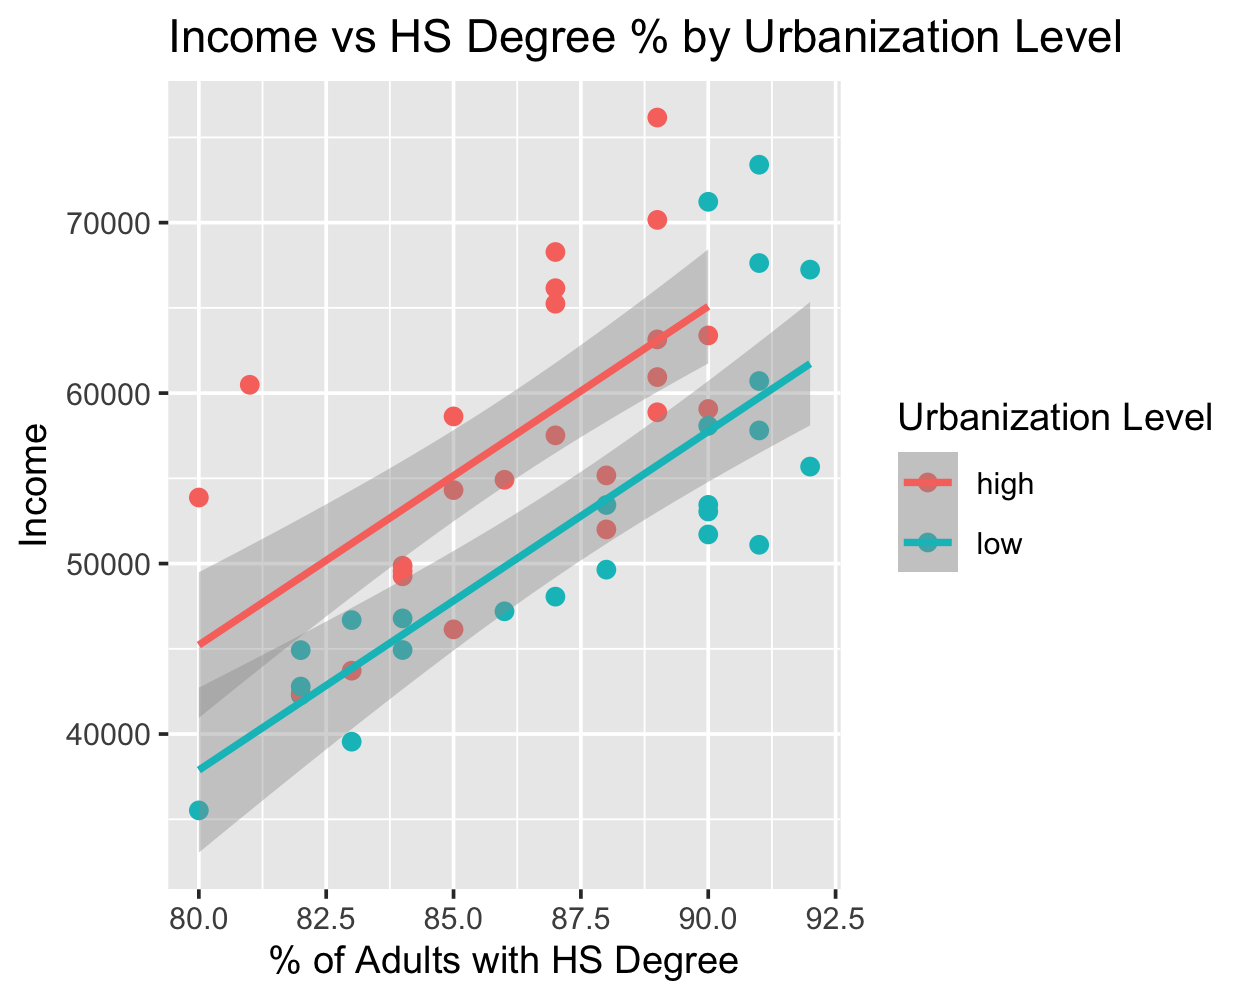

In [22]:
library(ggplot2)       # For data visualization
library(dplyr)         # For data manipulation


# Remove rows with missing values to avoid warnings
hate_crimes_clean <- hate_crimes %>%
  filter(!is.na(hs) & !is.na(income) & !is.na(urbanization))

# Create the scatterplot
ggplot(hate_crimes_clean, aes(x = hs, y = income, color = urbanization)) +
        geom_point(size = 2) +
        geom_parallel_slopes(aes(group = urbanization)) +
         labs(title = "Income vs HS Degree % by Urbanization Level",
             x = "% of Adults with HS Degree",
             y = "Income",
             color = "Urbanization Level")


❓Which regression line (high urbanization or low urbanization) appears to have the larger intercept?

**Answer:**

In [19]:
print ("High urbanization appears to have a larger intercept")

[1] "High urbanization appears to have a larger intercept"


Now let’s create a second scatterplot using the same variables, but this time draw the regression lines using `geom_smooth(method = "lm")`, which will allow for separate, non-parallel slopes for each urbanization group. 

**Code your scatter plot in the cell below.**

`geom_smooth()` using formula = 'y ~ x'


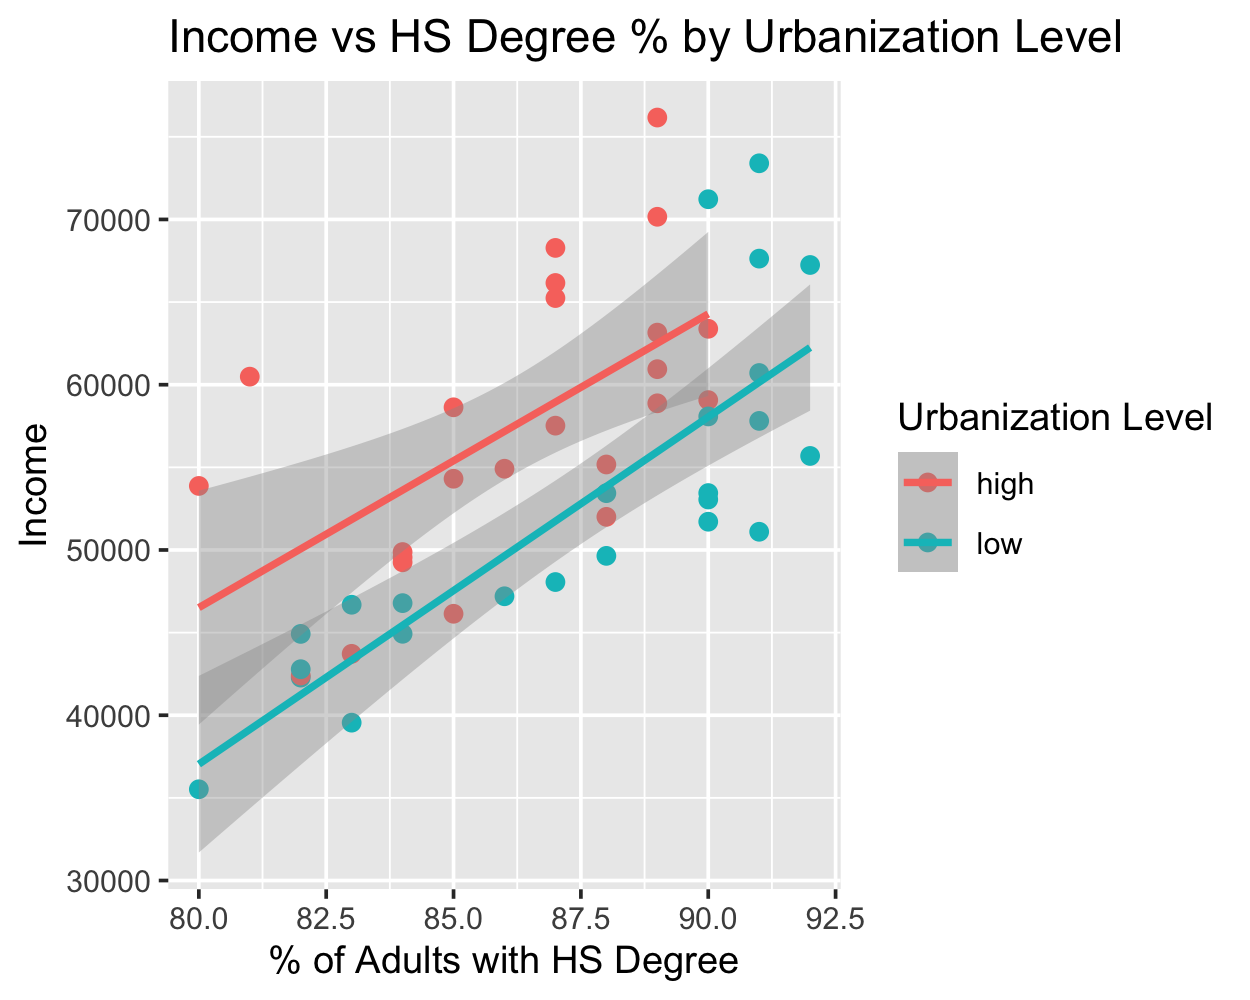

In [24]:
# Create the scatterplot
ggplot(hate_crimes_clean, aes(x = hs, y = income, color = urbanization)) +
        geom_point(size = 2) +
        geom_smooth(method = "lm",  aes(group = urbanization)) +
         labs(title = "Income vs HS Degree % by Urbanization Level",
             x = "% of Adults with HS Degree",
             y = "Income",
             color = "Urbanization Level")

❓Based on visually comparing the two models shown above, do you think it would be best to run a “parallel slopes” model (i.e. a model that estimates one shared slope for the two levels of urbanization), or a more complex “interaction model” (i.e. a model that estimates a separate slope for the two levels of urbanization)?

**Answer:**

In [26]:
print("I find Slopes nearly identical, so I think a parallel slopes model is appropriate.")



[1] "I find Slopes nearly identical, so I think a parallel slopes model is appropriate."


Fit the following two regression models that examine the relationship between household `income` (as response variable), and high-school education (`hs`) and `urbanization` as explanatory variables:

1. A parallel slopes model (i.e., no interaction between `hs` and `urbanization`). ❗️Save the data recipe and model under the variables `ps_rec` and `ps_mod`, respectively. 
1. A non-parallel slopes model (i.e., allow `hs` and `urbanization` to interact in your model). ❗️Save the data recipe and model under the variable: `nps_rec` and `nps_mod`, respectively.

**Code you your models in the cell below.**

In [25]:
# parallel slopes model

ps_rec = recipe(income ~ hs + urbanization, data = hate_crimes_clean) |>
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

ps_mod = mod |> fit(income ~ ., juice(ps_rec))

ps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
     (Intercept)                hs  urbanization_low  
         -113725              1987             -7333  


In [29]:
# non-parallel slopes model

# ❗️ you can use most of the code above, just add step_interact(~ starts_with("urbanization"):hs) to the recipe and
#    switch the variable names...
nps_rec = recipe(income ~ hs + urbanization, data = hate_crimes_clean) |>
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    step_interact(~ starts_with("urbanization"):hs) |> prep()  # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

nps_mod = mod |> fit(income ~ ., juice(nps_rec))

nps_mod



parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
          (Intercept)                     hs       urbanization_low  
               -95647                   1777                 -35394  
urbanization_low_x_hs  
                  324  


The following code creates a table of your model predictions over the training data. Calculate the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) for each model:

```r
rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)
```

1. Group rows by the `model` variable (use the `group_by` function).
1. Calculate the variance of income over the variance of your predictions for each model using the "grouped" data from the step above (use `summarize(r_squared = var(.pred) / var(income))`).

🎶 Note: you can also use the `glance` function with a model as input to find the coefficient of determination.

In [ ]:
glance(ps_mod)

❓Compare the adjusted proportion of variance accounted for in each model. Based on this comparison, which model do you prefer? Why? 

**Answer:**

❓Using your preferred model, based on your regression model parameters (and the data visualizations), is `income` greater in states that have lower or higher levels of `urbanization`? By how much?

**Hint:** use the `tidy` function with your model as input to access the parameters in a nice table.

**Answer:**

❓For every one percentage point increase of high-school educated adults in a state (`hs` variable), what is the associated average increase in `income`?

**Answer:**